In [13]:
import sys
import json
sys.path.append("/global/homes/s/seanjx/gigalens/src")

import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp

from astropy.io import fits
from astropy.visualization import simple_norm

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
import lenstronomy.Plots.model_plot as model_plot
from lenstronomy.Util import util

from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import tensorflow_probability.substrates.jax as tfp

import myfunctions
import dill

In [2]:
#load observation data, do masking
f=fits.open('psf238.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout238b.npy")

f=fits.open('final_94_drz.fits')
background_rms=0.00766512
exp_time=f[0].header["EXPTIME"]
deltaPix = f[0].header["D002SCAL"]
numPix = np.shape(observed_img)[0]

In [3]:
path = "output/"+"238_2024-08-05 11:00:04.378364"
prior, phys_model, phys_model_Forward, SingleSources = myfunctions.readJson(path+"/prior.json")[0:4]
err_map = np.load(path+"/err_map.npy")

sim_config = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
try: 
    #raise("I actually want MAP")
    inputFile = open(path+"/bestHMC.json")
    best_HMC = json.load(inputFile)
    print("HMC loaded")
    MAPorHMC = "HMC"
except: 
    prob_model = BackwardProbModel(prior, observed_img, err_map, background_rms=background_rms, exp_time=exp_time)
    best = np.load(path+"/best.npy")
    best_HMC = prob_model.bij.forward(best.tolist()[0])
    MAPorHMC = "MAP"
    print("MAP loaded")

HMC loaded


In [4]:
priorObjects = myfunctions.getPriors(phys_model)
numParams = myfunctions.countParameters(phys_model)
print(numParams,priorObjects)

38 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])


In [7]:
import dill
asdf = open(path+"/HMCsamples.pkl")
samples = dill.temp.load(asdf)

In [36]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples, (1,2,0,3)), independent_chain_ndims=2)
ESS= tfp.mcmc.effective_sample_size(jnp.transpose(samples, (1,2,0,3))[:,:,:,:].reshape(-1,38))
print(myfunctions.trunc(rhat,3))
print(f"Rhat mean: {myfunctions.trunc(np.mean(rhat),3)} min: {myfunctions.trunc(np.min(rhat),3)} max: {myfunctions.trunc(np.max(rhat),3)} <1.1: {np.sum(rhat<1.1)}")
print(myfunctions.trunc(ESS))
print(f"ESS mean: {myfunctions.trunc(np.mean(ESS),3)} min: {myfunctions.trunc(np.min(ESS),3)} max: {myfunctions.trunc(np.max(ESS),3)} >100: {np.sum(ESS>100)}")

[1.002 1.003 1.002 1.002 1.008 1.002 1.012 1.002 1.007 1.003 1.008 1.006
 1.015 1.001 1.004 1.01  1.011 1.003 1.009 1.009 1.009 1.    1.    1.001
 1.45  1.656 1.012 1.006 1.004 1.001 1.001 1.504 1.002 1.012 1.001 1.001
 0.999 1.001]
Rhat mean: 1.047 min: 0.999 max: 1.656 <1.1: 35
[12000. 11434. 12000. 12000. 12000. 12000. 12000. 12000. 11816. 12000.
 12000. 11974. 12000. 12000. 12000. 11751. 11823. 12000. 11489. 11599.
 12000. 12000. 12000. 11950. 12000. 12000. 12000. 12000. 12000. 11643.
 12000. 12000. 11831. 12000. 11627. 11420. 11759. 11785.]
ESS mean: 11892.321 min: 11420.839 max: 12000.001 >100: 38


(750, 16, 38)


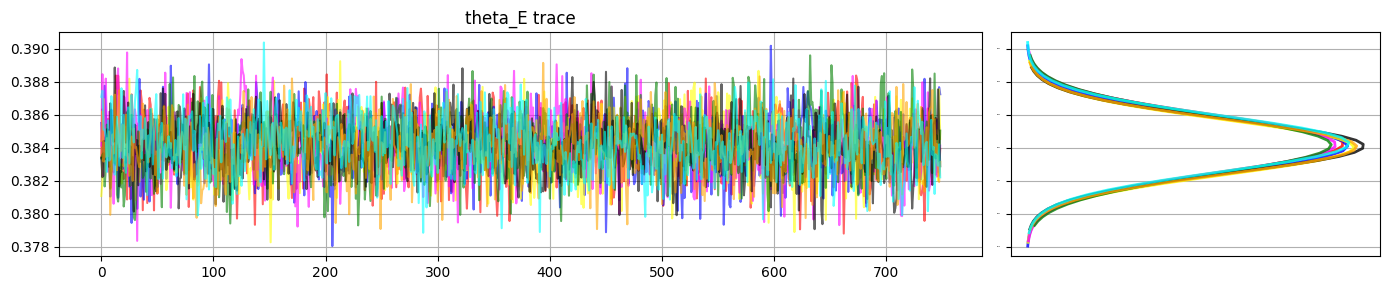

In [37]:
res_sates=samples.transpose(1, 0, 2, 3)
res_sates = res_sates.reshape(np.shape(res_sates)[0], np.shape(res_sates)[1]*np.shape(res_sates)[2],np.shape(res_sates)[3],)

c=res_sates
print(np.shape(res_sates))
#b=np.array(a).T
#c=np.array(a).T

from scipy.stats import norm
from random import choice
import matplotlib.colors as mcolors
p=5
d=8
steps1=0
steps2=-1
#all_colors = list(mcolors.CSS4_COLORS.keys())
#colors = [choice(all_colors) for _ in range(d)]
keys=list(best_HMC[0][0].keys())
klkl=keys[5-p]

# Traditional colors
colors = ['red', 'blue', 'yellow', 'magenta', 'green',  'black', 'orange', 'cyan',]
colors = colors[:d]  # Make sure we only use as many colors as required


fig = plt.figure(figsize=(14, 3))
gs = plt.GridSpec(1, 2, width_ratios=[1, .4], height_ratios=[1])
ax1 = plt.subplot(gs[0, 0],)

for i in range(d):
    ax1.plot(c[steps1:steps2,i,p], colors[i], label = f'{i}', alpha = 0.6)

plt.title(klkl + ' trace')

ax1.grid(True)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
for i in range(d):
    prob, bins = np.histogram(c[steps1:steps2,i,p], density = True, bins = 40)
    (mu, sigma) = norm.fit(c[steps1:steps2,i,p])

    y = norm.pdf(bins, mu, sigma)
    ax2.plot(y, bins, colors[i], linewidth=2, alpha = 0.8)

ax2.grid(True)
plt.gca().axes.get_xaxis().set_visible(False)
plt.tick_params(axis='y', labelsize=0)
plt.gca().axes.get_yaxis().set_visible(True)
plt.tight_layout()
plt.show()